### Understanding convolutions

http://setosa.io/ev/image-kernels/

In [1]:
from skimage.data import camera, chelsea
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

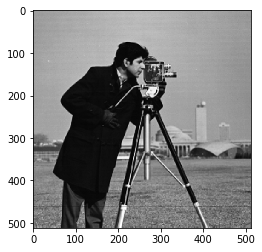

In [2]:
camerman = camera()
plt.imshow(camerman, cmap='gray')

In [3]:
camerman.shape

(512, 512)

In [4]:
t_cameraman = torch.from_numpy(camerman).float()
t_cameraman = t_cameraman.unsqueeze(0) # ads dimension at the begining
t_cameraman = t_cameraman.unsqueeze(0)
t_cameraman.shape

torch.Size([1, 1, 512, 512])

In [5]:
edge_filter  = torch.Tensor([[[[-1,-1,-1],
                               [-1, 8, -1], 
                               [-1,-1, -1]]
                             ]])
output = F.conv2d(t_cameraman, edge_filter, padding=1)
output

tensor([[[[778., 468., 490.,  ..., 458., 456., 760.],
          [463.,  -3.,  12.,  ...,   1.,   0., 456.],
          [477.,  -1.,  -4.,  ...,  -4.,  -1., 456.],
          ...,
          [362.,  -2.,   3.,  ...,  -8., -17., 330.],
          [357.,  -3.,   9.,  ...,  -3., -18., 327.],
          [601., 367., 384.,  ..., 361., 327., 551.]]]])

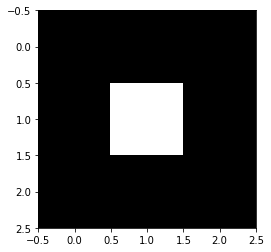

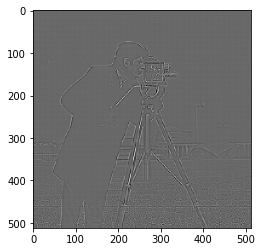

In [6]:
plt.figure()
plt.imshow(edge_filter.numpy()[0][0], cmap='gray')
plt.figure()
plt.imshow(output[0][0],cmap='gray')

In [7]:
left_sobel  = torch.Tensor([[[[1, 0, -1],
                              [1, 0, -1], 
                              [1, 0, -1]]]]) 


output = F.conv2d(t_cameraman, left_sobel, padding=1)
output

tensor([[[[-314.,   -7.,   -3.,  ...,   -2.,    0.,  304.],
          [-471.,   -5.,   -2.,  ...,   -1.,    0.,  456.],
          [-471.,    5.,    3.,  ...,    3.,    1.,  456.],
          ...,
          [-369.,  -24.,  -11.,  ...,   56.,   34.,  338.],
          [-369.,  -15.,   -9.,  ...,   51.,   30.,  339.],
          [-246.,  -10.,   -6.,  ...,   34.,   20.,  226.]]]])

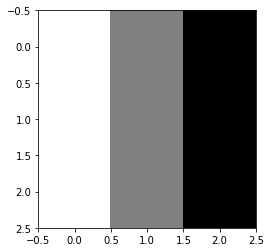

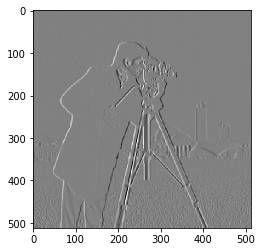

In [8]:
plt.figure()
plt.imshow(left_sobel.numpy()[0][0], cmap='gray')
plt.figure()
plt.imshow(output[0][0].numpy(),cmap='gray')

In [9]:
from torch.nn import Conv2d, MaxPool2d, AdaptiveAvgPool2d
from torch.nn.functional import max_pool2d, adaptive_max_pool2d

c = torch.randn((1,3,512,512))
conv2 = Conv2d(3,1,3)
pool = MaxPool2d(2, stride=2)

out = conv2(c)
print(out.shape)
out2 = pool(out)
print(out2.shape)

torch.Size([1, 1, 510, 510])
torch.Size([1, 1, 255, 255])


# RGB convolutions
![](rgb.gif)

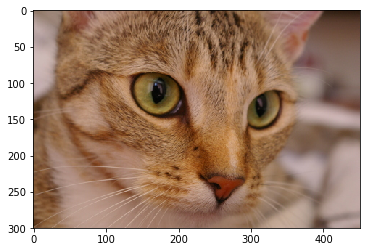

In [10]:
ch = chelsea()
plt.imshow(ch)

In [11]:
# Pytorch expects channels first 

t_ch = torch.from_numpy(ch).float()
print(t_ch.shape)
t_ch = t_ch.unsqueeze(0)
print(t_ch.shape)
t_ch = t_ch.permute([0,3,1,2])  #in numpy swappping from channels last to channels first can be done with moveaxis
print(t_ch.shape)
tch = t_ch / 255

torch.Size([300, 451, 3])
torch.Size([1, 300, 451, 3])
torch.Size([1, 3, 300, 451])


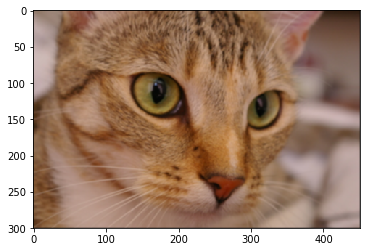

In [12]:
# since this is a color image we need to have a filter for each color-chanel thus we repeat the kernel 3 times

blur  = torch.Tensor([[[[1/16, 1/8, 1/16],
                        [ 1/8, 1/4,  1/8], 
                        [1/16, 1/8, 1/16]]]])
# left_sobel = left_sobel.repeat((1, 3, 1, 1))


output_r = F.conv2d(t_ch[:, 0:1, :, :], blur, padding=1)
output_g = F.conv2d(t_ch[:, 1:2, :, :], blur, padding=1)
output_b = F.conv2d(t_ch[:, 2:3, :, :], blur, padding=1)

image1 = torch.cat([output_r, output_g, output_b], dim=1)
image1 = np.moveaxis(image1.numpy()[0], 0, 2).astype('uint8')

plt.imshow(image1)

# Tips and tricks

- pytorch comes with handy utility functions like ones_like, ones, zeroes_like, etc. They come handy quite often

# Exercise 1

1. Create different sizes of bluring kernels. For instance (3x3, 7x7, 9x9) apply them on the cameraman picture  and compare the results side by side.

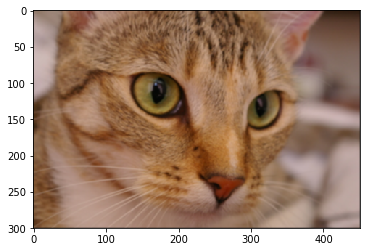

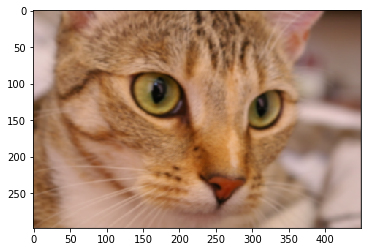

In [13]:
blur5 = torch.Tensor([[[[1/256, 4/256, 6/256, 4/256, 1/256],
                                [4/256, 16/256, 24/256, 16/256, 4/256], 
                                [6/256, 24/256, 36/256, 24/256, 36/256],
                                [4/256, 16/256, 24/256, 16/256, 4/256],
                                [1/256, 4/256, 6/256, 4/256, 1/256]
                               ]]])

output_r = F.conv2d(t_ch[:, 0:1, :, :], blur5, padding=1)
output_g = F.conv2d(t_ch[:, 1:2, :, :], blur5, padding=1)
output_b = F.conv2d(t_ch[:, 2:3, :, :], blur5, padding=1)

image2 = torch.cat([output_r, output_g, output_b], dim=1)
image2 = np.moveaxis(image2.numpy()[0], 0, 2).astype('uint8')

plt.imshow(image1)
plt.show()
plt.imshow(image2)

In [14]:
import scipy.stats as st
def gkern(kernlen=5, nsig=2):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    kernel = torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0).float()
    return kernel

print(gkern(kernlen=3))
blur

tensor([[[[0.0637, 0.1250, 0.0637],
          [0.1250, 0.2452, 0.1250],
          [0.0637, 0.1250, 0.0637]]]])


tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])

In [16]:
blur.shape

torch.Size([1, 1])

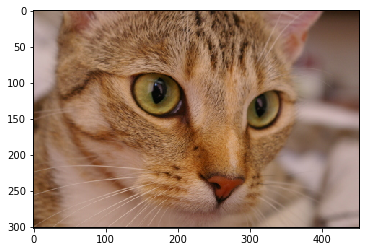

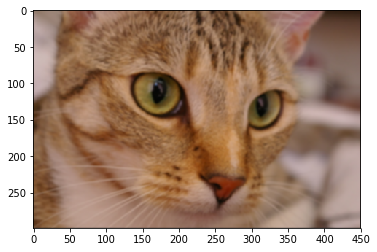

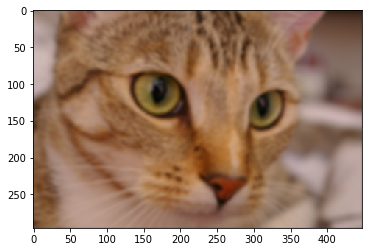

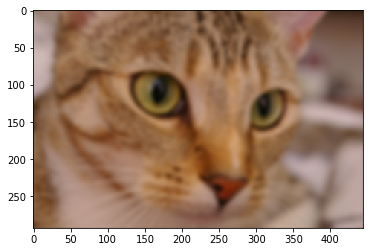

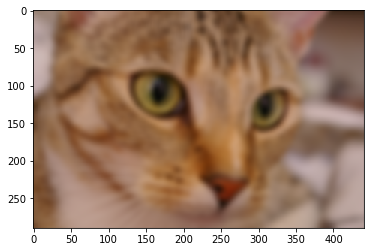

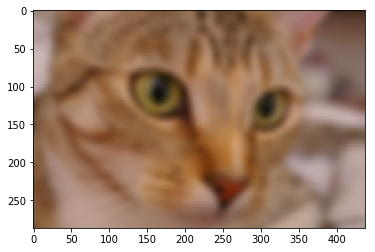

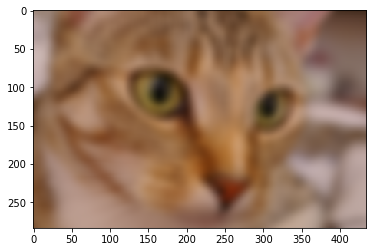

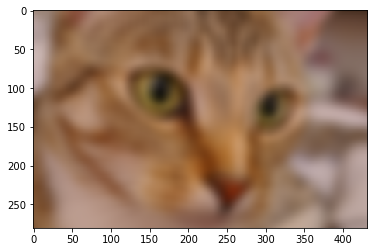

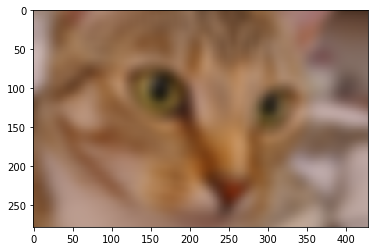

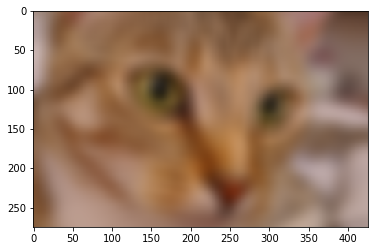

In [17]:
for i in range(1,31, 3):
    blur = gkern(kernlen=i)

    output_r = F.conv2d(t_ch[:, 0:1, :, :], blur, padding=1)
    output_g = F.conv2d(t_ch[:, 1:2, :, :], blur, padding=1)
    output_b = F.conv2d(t_ch[:, 2:3, :, :], blur, padding=1)

    image = torch.cat([output_r, output_g, output_b], dim=1)
    image = np.moveaxis(image.numpy()[0], 0, 2).astype('uint8')

    plt.imshow(image)
    plt.show()

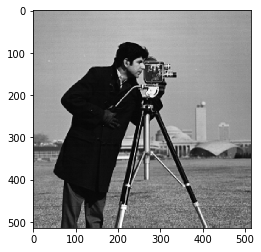

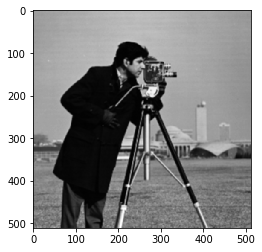

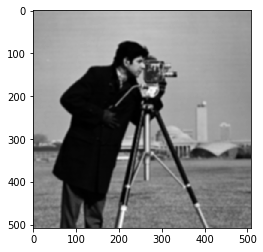

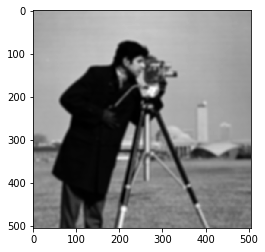

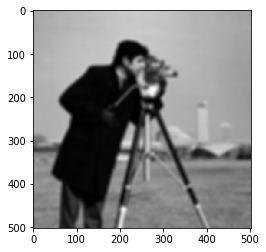

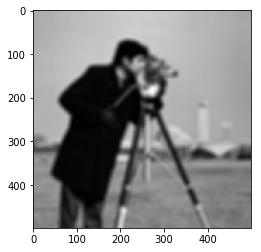

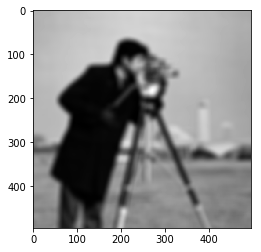

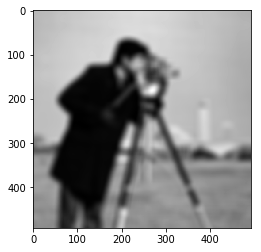

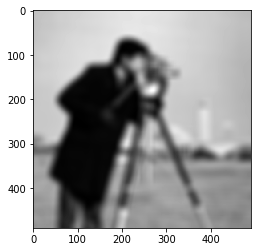

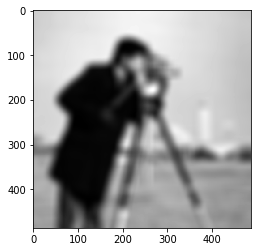

In [18]:
for i in range(1,31, 3):
    blur = gkern(kernlen=i)
    
    output = F.conv2d(t_cameraman, blur, padding=1)
    
    plt.imshow(output[0][0].numpy(),cmap='gray')
    plt.show()